In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [10]:
import sys, os, pathlib
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [11]:
config = project.core.fileio.load_config('2025-11-05_config.yaml')
config['dataset']

Loading 2025-11-05_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'variant': '2025-11-02', 'subjects': '2025-11-05_optimized.csv'},
 'metadata': {'unit_policy': 'prefer_metadata', 'default_unit': 0.01},
 'selectors': {'volume_tag': 'volume_vr',
  'mat_fields_tag': 'mat_fields_vr',
  'sim_fields_tag': 'sim_fields_vr',
  'img_fields_tag': 'img_fields_vr',
  'material_tag': 'material_vr',
  'image_tag': 'solid_texture_vr'}}

In [12]:
%autoreload
import project.datasets.shapenet
project.datasets.shapenet._resolve_names_from_tags({'input_image': 'image-v1'})

{'binary_mask': 'mask',
 'surface_mesh': 'trimesh',
 'region_mask': 'mask_regions',
 'volume_mesh': 'mask_regions_tetmesh',
 'material_mask': 'mask_regions_material',
 'density_field': 'mask_regions_material_density',
 'elastic_field': 'mask_regions_material_elastic',
 'input_image': 'mask_regions_material_image-v1',
 'material_mesh': 'mask_regions_material_tetmesh_mat',
 'simulate_mesh': 'mask_regions_material_tetmesh_mat_sim',
 'interp_mesh': 'mask_regions_material_image-v1_tetmesh_mat_int'}

In [13]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


1115

In [14]:
train_config = config['training'].copy()
train_config

{'split': {'test_ratio': 0.2, 'val_ratio': 0.1, 'seed': 0},
 'loader': {'batch_size': 1,
  'shuffle': True,
  'num_workers': 4,
  'pin_memory': True},
 'model': {'_class': 'UNet3D',
  'conv_channels': 16,
  'n_enc_blocks': 3,
  'n_conv_units': 2,
  'n_init_units': 1,
  'kernel_size': 3,
  'relu_leak': 0.01,
  'norm_type': 'group',
  'num_groups': 8,
  'pooling_type': 'max',
  'upsample_mode': 'nearest',
  'output_func': 'pow10'},
 'optimizer': {'_class': 'AdamW', 'lr': 0.0001},
 'pde_adapter': {'nu_value': 0.4,
  'rho_bias': 1000.0,
  'rho_known': False,
  'scalar_degree': 1,
  'vector_degree': 1},
 'pde_solver': {'_class': 'WarpFEMSolver', 'tv_reg_weight': 0.0001},
 'trainer': {'supervised': False, 'num_epochs': 100}}

In [16]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, key='category', **split_kws)

0.2135561745589601


In [17]:
import project.datasets.torch
train_set = project.datasets.torch.TorchDataset(train_ex)
test_set = project.datasets.torch.TorchDataset(test_ex)
val_set = project.datasets.torch.TorchDataset(val_ex)
collate_fn = project.datasets.torch.collate_fn

In [18]:
loader_kws = train_config['loader']
train_loader = torch.utils.data.DataLoader(train_set, **loader_kws)
test_loader = torch.utils.data.DataLoader(test_set, **loader_kws)
val_loader = torch.utils.data.DataLoader(val_set, **loader_kws)

In [19]:
import project.models
model_kws = train_config['model'].copy()
model_cls = getattr(project.models, model_kws.pop('_class'))
model = model_cls(in_channels=1, out_channels=1, **model_kws)

In [20]:
optimizer_kws = train_config['optimizer'].copy()
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

In [21]:
import project.evaluation
evaluator = project.evaluation.Evaluator()

In [24]:
import project.physics
pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')
pde_adapter_kws = train_config['pde_adapter'].copy()
pde_adapter = project.physics.PhysicsAdapter(pde_solver_cls=pde_solver_cls, **pde_adapter_kws)
pde_adapter, pde_solver_cls

(<project.physics.PhysicsAdapter at 0x14626670be90>, 'WarpFEMSolver')

In [27]:
import project.training
trainer_kws = train_config['trainer'].copy()
supervised = trainer_kws.pop('supervised', False)
trainer = project.training.Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    evaluator=evaluator,
    physics_adapter=pde_adapter,
    supervised=supervised
)

In [29]:
trainer.load_state('pde.checkpoint')

Loading pde.checkpoint


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/training.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


RuntimeError: Error(s) in loading state_dict for UNet3D:
	size mismatch for encoder.level0.conv_block.unit0.conv.weight: copying a param with shape torch.Size([8, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3, 3]).
	size mismatch for encoder.level0.conv_block.unit0.norm.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.level0.conv_block.unit0.norm.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.level1.conv_block.unit0.conv.weight: copying a param with shape torch.Size([16, 8, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3, 3]).
	size mismatch for encoder.level1.conv_block.unit0.norm.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.level1.conv_block.unit0.norm.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.level1.conv_block.unit1.conv.weight: copying a param with shape torch.Size([16, 16, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for encoder.level1.conv_block.unit1.norm.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.level1.conv_block.unit1.norm.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.level2.conv_block.unit0.conv.weight: copying a param with shape torch.Size([32, 16, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3, 3]).
	size mismatch for encoder.level2.conv_block.unit0.norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.level2.conv_block.unit0.norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.level2.conv_block.unit1.conv.weight: copying a param with shape torch.Size([32, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).
	size mismatch for encoder.level2.conv_block.unit1.norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.level2.conv_block.unit1.norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.level1.conv_block.unit0.conv.weight: copying a param with shape torch.Size([16, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 96, 3, 3, 3]).
	size mismatch for decoder.level1.conv_block.unit0.norm.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.level1.conv_block.unit0.norm.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.level1.conv_block.unit1.conv.weight: copying a param with shape torch.Size([16, 16, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for decoder.level1.conv_block.unit1.norm.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.level1.conv_block.unit1.norm.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.level0.conv_block.unit0.conv.weight: copying a param with shape torch.Size([8, 24, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 48, 3, 3, 3]).
	size mismatch for decoder.level0.conv_block.unit0.norm.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.level0.conv_block.unit0.norm.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.level0.conv_block.unit1.conv.weight: copying a param with shape torch.Size([8, 8, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3, 3]).
	size mismatch for decoder.level0.conv_block.unit1.norm.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.level0.conv_block.unit1.norm.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for output_conv.weight: copying a param with shape torch.Size([1, 8, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 16, 1, 1, 1]).

In [45]:
trainer.train(num_epochs=100)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/nibabel/loadsave.py", line 101, in load
    stat_result = os.stat(filename)
                  ^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/TEST/952b776eacc0f0cc2e0bc329949c179c/images/solid_texture_vr.nii.gz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/datasets/torch.py", line 21, in __getitem__
    self.cache[idx] = self.load_example(idx)
              ^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/datasets/torch.py", line 26, in load_example
    image = fileio.load_nibabel(ex.paths['input_image'])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/core/fileio.py", line 9, in load_nibabel
    return nib.load(path)
           ^^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/nibabel/loadsave.py", line 103, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")
FileNotFoundError: No such file or no access: '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/TEST/952b776eacc0f0cc2e0bc329949c179c/images/solid_texture_vr.nii.gz'


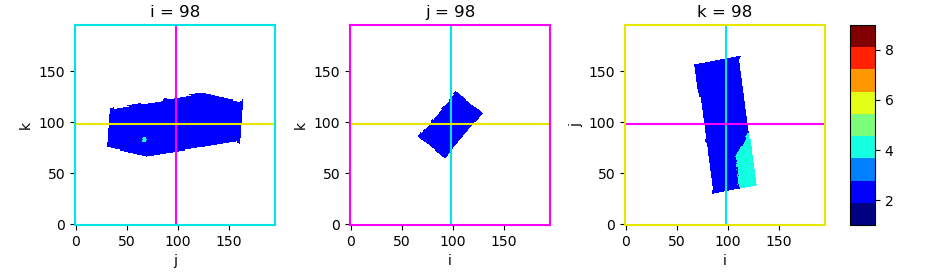

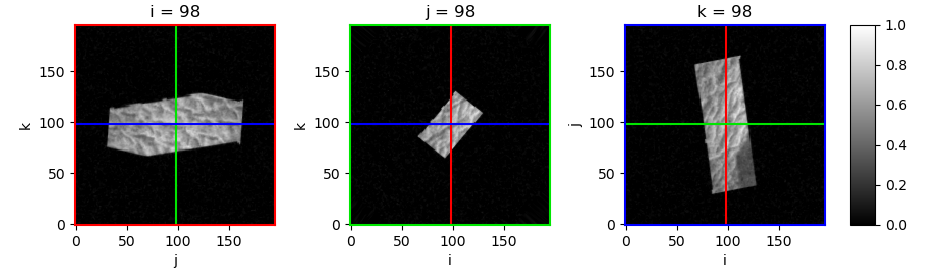

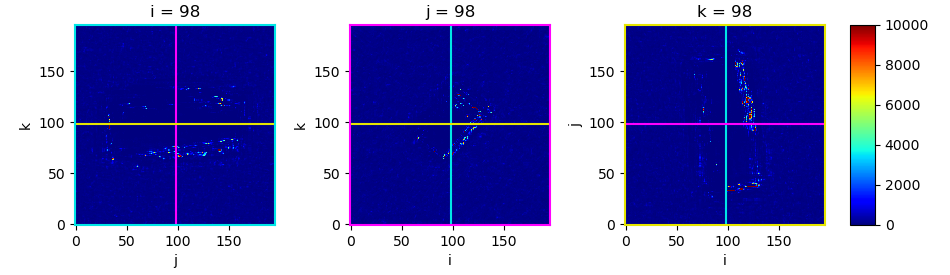

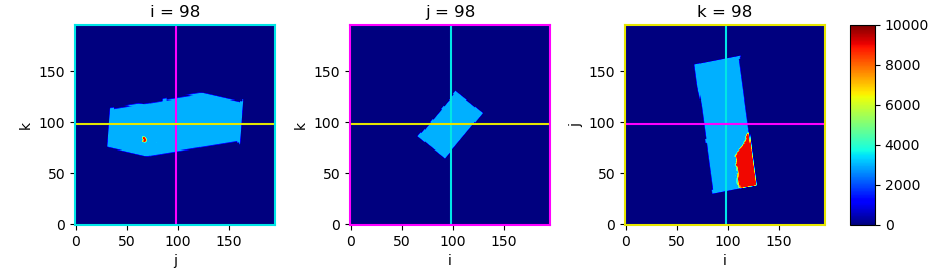

In [48]:
import project.visual.matplotlib
import matplotlib.pyplot as plt

def colormap(name, n=None, under=None):
    cmap = plt.get_cmap('jet', n)
    if under:
        cmap.set_under(under)
    return cmap

mm = mask[0][0].detach().cpu().numpy()
im = image[0][0].detach().cpu().numpy()
Ep = E_pred[0][0].detach().cpu().numpy()
Et = E_true[0][0].detach().cpu().numpy()

_ = project.visual.matplotlib.show_image_slices(mm, cmap=colormap('jet', 9, under='white'), clim=(1,9), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(im, cmap='gray', clim=(0,1))
_ = project.visual.matplotlib.show_image_slices(Ep, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(Et, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')

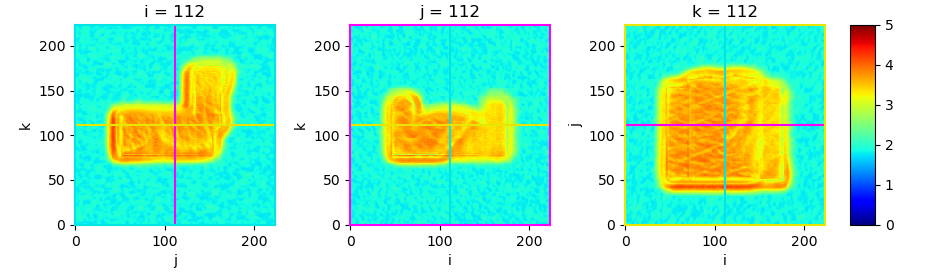

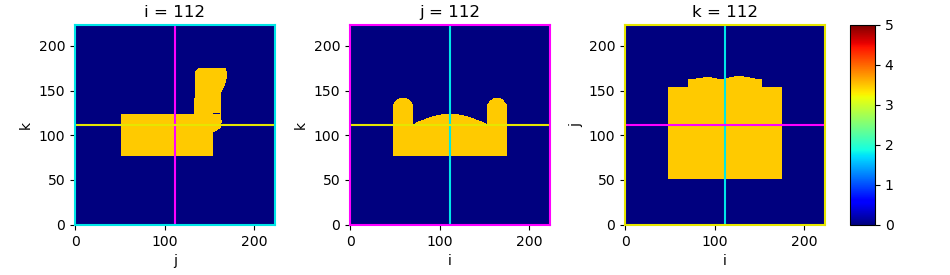

In [195]:
def postprocess(x, lo, hi, eps=1e-5):
    x = np.asarray(x)
    x = np.maximum(x, eps)
    x = np.log10(x)
    x = np.clip(x, lo, hi)
    return x

lo, hi = (0, 5)
n_bins = 500

pp = postprocess(Ep, lo, hi)
pt = postprocess(Et, lo, hi)

cmap = colormap('jet', n_bins, under='black')

_ = project.visual.matplotlib.show_image_slices(pp, clim=(lo, hi), cmap=cmap, colors='cmy')
_ = project.visual.matplotlib.show_image_slices(pt, clim=(lo, hi), cmap=cmap, colors='cmy')

10.0


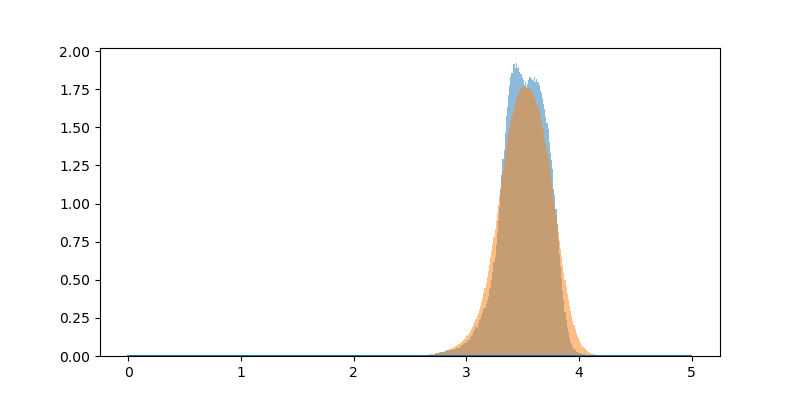

In [251]:
sigma_w = 0.1
spacing = (hi - lo) / n_bins
sigma = sigma_w / spacing
print(sigma)

hist, edges = np.histogram(pp[mm>0], bins=np.linspace(lo, hi, n_bins + 1), density=True)
dens = scipy.ndimage.gaussian_filter1d(hist, sigma=sigma, mode='nearest')

import sklearn
clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=1)
labels = clustering.fit_predict(dens.reshape(-1, 1))

left = edges[:-1]
right = edges[1:]
width = right - left

fig, ax = plt.subplots(figsize=(8,4))

_ = ax.bar(left, hist, width, align='edge', alpha=0.5)
_ = ax.bar(left, dens, width, align='edge', alpha=0.5)
_ = ax.plot(left, labels)